<a href="https://colab.research.google.com/github/raihansulaiman/data-analytics/blob/main/NLP_AmazonKindleReviews_RaihanSulaiman.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Binary Text Classification using Neural Language Processing
**Created by Raihan Sulaiman (1494037162101-989)**

The objectives of model:

*   The dataset that will be used has a minimum of 1000 samples.
*   The validation set is 20% of the total dataset.
*   The accuracy of the model is at least 75% on the train set and validation set.



Interact with Kaggle

In [ ]:
# Install kaggle package
!pip install -q kaggle

# Upload kaggle's beta API to interact with kaggle's dataset
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"raihansulaiman","key":"216c3740c72a4fe118bde49306fe9050"}'}

Download and Manage Kaggle Dataset Directories

In [ ]:
# Create directory and change file permission
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

# Download dataset
!kaggle datasets download -d meetn heagadia/amazon-kindle-book-review-for-sentiment-analysis

!mkdir amazon-kindle-book-review-for-sentiment-analysis
!unzip amazon-kindle-book-review-for-sentiment-analysis.zip -d amazon-kindle-book-review-for-sentiment-analysis
!ls amazon-kindle-book-review-for-sentiment-analysis

kaggle.json
  0% 0.00/6.38M [00:00<?, ?B/s]
100% 6.38M/6.38M [00:00<00:00, 71.3MB/s]
Archive:  amazon-kindle-book-review-for-sentiment-analysis.zip
  inflating: amazon-kindle-book-review-for-sentiment-analysis/all_kindle_review .csv  
  inflating: amazon-kindle-book-review-for-sentiment-analysis/preprocessed_kindle_review .csv  
'all_kindle_review .csv'  'preprocessed_kindle_review .csv'


Import Necessary Modules

In [ ]:
import pandas as pd
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM,Dense,Embedding,Dropout,SpatialDropout1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


Drop Columns

In [ ]:
dataset = pd.read_csv('amazon-kindle-book-review-for-sentiment-analysis/preprocessed_kindle_review .csv', sep=',')
dataset = dataset.drop(columns=['Unnamed: 0', 'summary'])
dataset.head()

,rating,reviewText
0,5,This book was the very first bookmobile book I...
1,1,"When I read the description for this book, I c..."
2,5,I just had to edit this review. This book is a...
3,5,I don't normally buy 'mystery' novels because ...
4,5,"This isn't the kind of book I normally read, a..."


In [ ]:
# Checking the size of dataset
dataset.shape

(12000, 2)

In [ ]:
# Checking the information of dataset
print(dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   rating      12000 non-null  int64 
 1   reviewText  12000 non-null  object
dtypes: int64(1), object(1)
memory usage: 187.6+ KB
None


In [ ]:
# Checking for null values
dataset.isnull().sum()

rating        0
reviewText    0
dtype: int64

In [ ]:
# Counting unique values of rating
r = dataset.rating.value_counts()
r

5    3000
4    3000
1    2000
3    2000
2    2000
Name: rating, dtype: int64

In [ ]:
# PLotting Rating plotly
fig = go.Figure([go.Bar(x=r.index, y=r.values,text=r.values)])
fig.update_layout(title='Distribution of the Rating using ploty')
fig.show()

Preprocessing Dataset

In [ ]:
# Set low string
dataset["reviewText"] = dataset["reviewText"].str.lower()

# Remove punctuation
import string
PUNCT_TO_REMOVE = string.punctuation
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

dataset["reviewText"] = dataset["reviewText"].apply(lambda text: remove_punctuation(text))

# Remove stop words
STOPWORDS = set(stopwords.words('english'))
def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

dataset["reviewText"] = dataset["reviewText"].apply(lambda text: remove_stopwords(text))

# Set lemmatizer
lemmatizer = WordNetLemmatizer()
wordnet_map = {"N":wordnet.NOUN, "V":wordnet.VERB, "J":wordnet.ADJ, "R":wordnet.ADV}
def lemmatize_words(text):
    pos_tagged_text = nltk.pos_tag(text.split())
    return " ".join([lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged_text])

dataset["reviewText"] = dataset["reviewText"].apply(lambda text: lemmatize_words(text))
dataset

,rating,reviewText
0,5,book first bookmobile book buy school book clu...
1,1,read description book couldnt wait read downlo...
2,5,edit review book believe get right update rewr...
3,5,dont normally buy mystery novels dont like how...
4,5,isnt kind book normally read although try limi...
...,...,...
11995,2,read certain passage twicetypos wish build rel...
11996,3,expect yet interesting book usually don8216t r...
11997,5,dragon knight world knight ride dragon slay wi...
11998,4,since story short hard say much without give a...


In [ ]:
dataset["rating"] = dataset["rating"].apply(lambda x: 1 if x<4 else 0)
dataset.tail()

,rating,reviewText
11995,1,read certain passage twicetypos wish build rel...
11996,1,expect yet interesting book usually don8216t r...
11997,0,dragon knight world knight ride dragon slay wi...
11998,0,since story short hard say much without give a...
11999,0,1922 amazing collection info symbols culture a...


Data Splitting and Tokenization

In [ ]:
# Split dataset into data train and data test
review = dataset['reviewText'].values
y = dataset['rating'].values
review_train, review_test, y_train, y_test = train_test_split(review, y, test_size=0.2, shuffle=True)

In [ ]:
# Text tokenization
tokenizer = Tokenizer(num_words=10000, oov_token='x')
tokenizer.fit_on_texts(review_train) 
tokenizer.fit_on_texts(review_test)
vocab_size = len(tokenizer.word_index) + 1
sequence_train = tokenizer.texts_to_sequences(review_train)
sequence_test = tokenizer.texts_to_sequences(review_test)
 
padded_train = pad_sequences(sequence_train, maxlen=200, truncating= "post") 
padded_test = pad_sequences(sequence_test, maxlen=200, truncating= "post")

Compile Model

In [ ]:
# Create the model
embedding_vector_length = 32
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_vector_length, input_length=200),
    tf.keras.layers.SpatialDropout1D(0.25),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 200, 32)           1330944   
                                                                 
 spatial_dropout1d_5 (Spatia  (None, 200, 32)          0         
 lDropout1D)                                                     
                                                                 
 lstm_5 (LSTM)               (None, 64)                24832     
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_10 (Dense)            (None, 128)               8320      
                                                                 
 dense_11 (Dense)            (None, 1)                 129       
                                                      

Data Training

In [ ]:
# Create callback function
class callbackFunction(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.9 and logs.get('val_accuracy')>0.80):
      print("\n the accuracy model is above 80%!")
      self.model.stop_training = True
callbacks = callbackFunction()

# Train the model
num_epochs = 20
history = model.fit(padded_train, y_train, epochs=num_epochs, 
                    validation_data=(padded_test, y_test), verbose=2, callbacks=[callbacks])

Epoch 1/20
Epoch 2/20
300/300 - 31s - loss: 0.3447 - accuracy: 0.8602 - val_loss: 0.4571 - val_accuracy: 0.7983 - 31s/epoch - 102ms/step
Epoch 3/20

 the accuracy model is above 80%!
300/300 - 29s - loss: 0.2564 - accuracy: 0.9017 - val_loss: 0.4678 - val_accuracy: 0.8058 - 29s/epoch - 96ms/step


Visualization of Accuracy and Loss Model

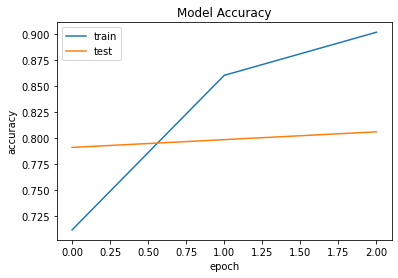

In [ ]:
# plot of accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

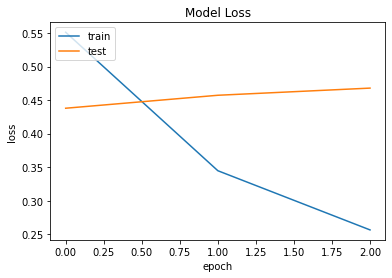

In [ ]:
# plot of loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()